# Authors
* Willis Tan
* Alice Lue

# Summary of Findings


### Introduction
The prediction problem we are attempting is predicting the reach (number of views) of an ad. This is a regression problem. For the baseline model, we are using the variables Duration and Spend to predict Impressions. These 2 variables seem to have the largest effect on Impressions. If the ad played for a longer time, by convention, it would have a higher number of Impressions. Also, if the spend on the ad was higher, then the ad would be expected to reach more viewers. We used R^2 to evalutate the accuracy of our predictions and trained 100 models to evaluate the variance fo the scores. For our improved model, we used the variables Duration, Spend, NumberInterestGroups, and CountryCode to predict Impressions. We used NumberInterestGroups because if the ad targeted specific interest groups, then the ad would be expected to reach less viewers than ads who target all viewers. We also used CountryCode because ads in countries with a larger population would be expected to gain more views. To evaluate the accuracy, we used R^2 and trained 100 models to evaluate the variance fo the scores.

### Baseline Model
For the baseline model, we are using 2 columns (spend and duration) as our features. These features are all quantitative. For this model we used LinearRegression to model. As a result, we got a total score of 0.7, but when we  used the cross_val_score function to generate 100 models to test the variance of the model there was a very high variance found using the current model, therefore the model we currently have is not good.

### Final Model
For our improved model, we used CountryCode and NumberInterestGroups. These 2 columns were originally ordinal, but we transformed them into quantitative variables. For the CountryCode, we changed the country code to its corresponding population. Countries with a greater population are expected to have more views. For the NumberInterestGroups, we derived it from the Interests column, by spliting each value by a comma to determine how many interests each ad targeted. Ads with more interests being targeted are expected to have more views. We also transformed all the quantitative features using SimpleIMputer to fill in null values with 0.Then we used a PolynomialTransformer on Spend, since Spend impacts Impressions exponentially. To select the best model, we created four different models and calculated the scores of the 4 models. We used the RandomForestRegressor as our model, because even though DecisionTreeRegressor yielded a higher score, the variance using that model was significantly higher than using the RandomForestRegressor. 

### Fairness Evaluation
For the fairness evaluation, we decided to test the model against ads whose expenditures were in the top 10% and bottom 10%. Essentially, we want to see if the model has any bias towards ads that spend more or vice-versa. 

The test statistic that we will use for our permutation test is the absolute difference between the RMSE of both subsets.The significance level of our permutation test is 0.01. 

__Null Hypothesis__: The absolute difference between the RMSE of the groups is zero.  
__Alternate Hypothesis__: The absolute difference between the RMSE of the groups is greater than zero.  

Our observed statistic is 329950.484412926.  

We used 1000 as the number of permutations needed for the test. After 1000 permutations, we computed the number ofstatistics that were greater than our observed statistic and calculated the mean. This resulted in a p-value of 0.0. Since 0.0 < 0.01, we reject the null hypothesis. Thus, there is suggestion that our Random Forest model does not predict fairly for both subsets.

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Baseline Model
We converted StartDate and EndDate into a feature that showed the duration of the ad in hours.

In [2]:
ads_18 = pd.read_csv("PoliticalAds2018.csv")
ads_19 = pd.read_csv("PoliticalAds2019.csv")
ads_18["StartDate"] = pd.to_datetime(ads_18["StartDate"])
ads_19["StartDate"] = pd.to_datetime(ads_19["StartDate"])
ads_18["EndDate"] = pd.to_datetime(ads_18["EndDate"])
ads_19["EndDate"] = pd.to_datetime(ads_19["EndDate"])

idx_18 = ads_18.EndDate < ads_18.StartDate
ads_18.loc[idx_18] = ads_18.loc[idx_18].rename(columns={'EndDate':'StartDate','StartDate':'EndDate'})
idx_19 = ads_19.EndDate < ads_19.StartDate
ads_19.loc[idx_19] = ads_19.loc[idx_19].rename(columns={'EndDate':'StartDate','StartDate':'EndDate'})

avg_runtime_18 = (ads_18.EndDate - ads_18.StartDate).mean()
avg_runtime_19 = (ads_19.EndDate - ads_19.StartDate).mean()
ads_18.EndDate = ads_18.EndDate.fillna(avg_runtime_18 + ads_18.StartDate)
ads_19.EndDate = ads_19.EndDate.fillna(avg_runtime_19 + ads_19.StartDate)
df = pd.concat([ads_18,ads_19], ignore_index=True)
df['Duration'] = df.EndDate - df.StartDate

not_needed = ['OrganizationName', 'BillingAddress',
               'CandidateBallotInformation', 'PayingAdvertiserName', 
               'CountryCode', 'Regions (Included)', 'Regions (Excluded)',
               'Electoral Districts (Included)', 'Electoral Districts (Excluded)',
               'Radius Targeting (Included)', 'Radius Targeting (Excluded)',
               'Metros (Included)', 'Metros (Excluded)', 'Postal Codes (Included)',
               'Postal Codes (Excluded)', 'Location Categories (Included)',
               'Location Categories (Excluded)', 'Targeting Connection Type', 'Targeting Carrier (ISP)']

df2 = df.drop(not_needed, axis = 1)
hours = df2.Duration.astype('timedelta64[h]')
df2['Duration'] = hours
df2 = df2.drop('StartDate', axis = 1)
df2 = df2.drop('EndDate', axis = 1)

We separated the columns that were objects with columns that weren't objects.

In [3]:
types = df2[["Spend","Duration"]].dtypes
catcols = types.loc[types == np.object].index
numcols = types.loc[types != np.object].index
types

Spend         int64
Duration    float64
dtype: object

This is our baseline model. We used SimpleImputer, OneHotEncoder and PCA to handle all the categorical variables. We filled in all the null values with NULL. For the quantititaive variables we used SimpleImputer to fill all the null values with zero. Lastly, we used LinearRegression as our model. We ended up with a score of 0.71

In [4]:
cats = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='NULL')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('pca', PCA(svd_solver='full', n_components=0.99))
])

ct = ColumnTransformer([
    ('catcols', cats, catcols),
    ('numcols', SimpleImputer(strategy='constant', fill_value=0), numcols)
])

b_pl = Pipeline([('feats', ct), ('reg', LinearRegression())])
b_pl.fit(df2[['Spend', 'Duration']], df2.Impressions)
preds = b_pl.predict(df2[['Spend', 'Duration']])
np.sqrt(np.mean((preds - df2.Impressions)**2))
b_pl.score(df2[['Spend', 'Duration']], df2.Impressions)

0.7094744225346112

We found scores in 100 models with different sample of data to determine the variance of our baseline model.

In [18]:
out = []
for _ in range(1000):
    X_tr, X_ts, y_tr, y_ts = train_test_split(df2[['Spend',"Duration"]], df2.Impressions, test_size=4)
    b_pl.fit(X_tr, y_tr)
    out.append(b_pl.score(X_ts, y_ts))

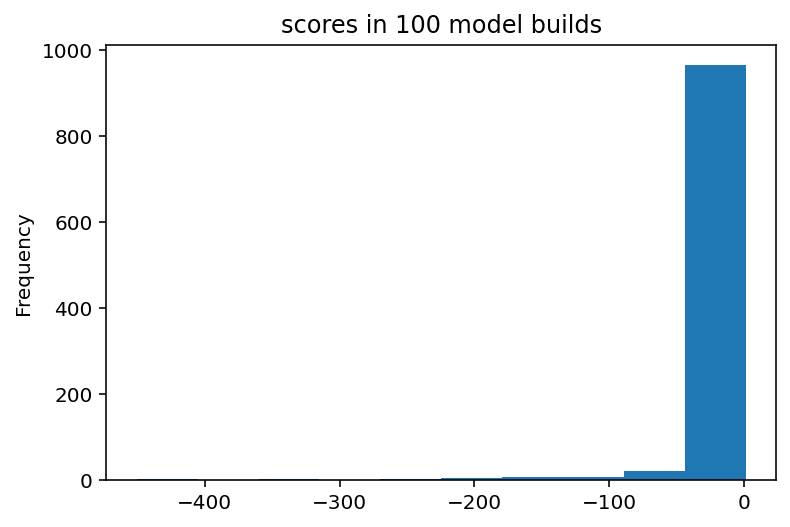

In [19]:
pd.Series(out).plot(kind='hist', title='scores in 100 model builds');

The variance is very high, therefore this baseline model is not good.

### Final Model

These are all the feature transformations for the improved model. We converted Interest columns into a quantitative column thatrepresents the number of interests targeted by the ad. We converted Spend to USD dollars, so that spend is standardized. Wealso converted CountryCode to its corresponding population value. Lastly, we dropped data that were outliers.

In [7]:
df2['NumberInterestGroups'] = df2["Interests"].str.split(",").fillna("").apply(lambda x: len(x))
def convert_to_usd(row):
    x = row['Currency Code']
    y = row['Spend']
    rates = {'CAD': 0.71774,
             'USD': 1,
             'AUD': 0.65254,
             'GBP': 1.23979,
             'EUR': 1.08331}
    return int(round(rates[x] * y))
df2.Spend = df.apply(convert_to_usd, axis=1)
df2 = df2.drop(['Currency Code'], axis = 1)

pops = {"netherlands":17.28, "united states": 328.2, "denmark": 5.806, 
        "norway": 5.368, "switzerland": 8.57, "canada": 37.59,
        "ireland": 4.904, "france": 66.99, "united kingdom": 66.65,
        "nigeria": 195.9, "sweden": 10.23, "australia": 24.99,
        "finland": 5.518, "india": 1353, "united arab emirates": 9.631,
        "germany": 83.02, "argentina": 44.49, "turkey": 82,
        "south africa": 57.78, "kuwait": 4.137, "lithuania": 2.794,
        "new zealand": 4.886, "poland": 37.97, "brazil": 209.5,
        "puerto rico": 3.194, "chile": 18.73, "iraq": 38.43,
        "belgium": 11.46, "austria": 24.99}

df2["CountryCode"] = df["CountryCode"].map(pops)
df2 = df2[["Spend", "Impressions", "CountryCode", "Duration", "NumberInterestGroups"]]
df2 = df2[df2["Duration"] > 0]
df2 = df2[df2["Impressions"] < df2["Impressions"].quantile(0.98)]

We made 4 models using RandomForestRegressor, KNeighborsRegressor, DecisionTreeRegressor, and LogisticRegression to find the best model for our data. Although the DecisionTreeRegressor scored slightly higher than the RandomForestRegressor, we decided to still use the RandomForestRegressor because this model yielded less variance than the DecisionTreeRegressor.

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(df2[['Spend', 'NumberInterestGroups', "CountryCode", "Duration"]],
                                                    df2.Impressions, test_size=0.25)

random_forest = RandomForestRegressor(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
score_random_forest = random_forest.score(X_train, Y_train)

knn = KNeighborsRegressor(n_neighbors = 3) 
knn.fit(X_train, Y_train)  
Y_pred = knn.predict(X_test)  
score_knn = knn.score(X_train, Y_train)

decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, Y_train)  
Y_pred = decision_tree.predict(X_test)  
score_decision_tree = decision_tree.score(X_train, Y_train)

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

score_log = logreg.score(X_train, Y_train)


results = pd.DataFrame({
    'Model': ['KNN',
              'Logistic Regression', 
              'Random Forest', 
              'Decision Tree'],
    'Score': [score_knn, score_log, score_random_forest, score_decision_tree]})
result_df = results.sort_values(by='Score')
result_df = result_df.set_index('Score')
result_df

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model
Score,
0.012759,Logistic Regression
0.839360,KNN
0.966541,Random Forest
0.999835,Decision Tree


We found the relative importance of each feature. Spend ended up being significantly more important than all the other features

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df2.drop(['Impressions'], axis=1), df2.Impressions, test_size=0.10)
reg = RandomForestRegressor()
reg.fit(X_train, y_train)
dict(zip(df2.drop(['Impressions'], axis=1).columns, reg.feature_importances_))

{'Spend': 0.8288036095370255,
 'CountryCode': 0.07869998753182814,
 'Duration': 0.07141424646244499,
 'NumberInterestGroups': 0.02108215646870133}

We attempted a gridsearch to find the best parameter for RandomForestRegressor. We could have done more parameters, but unfortunately the code would have run for too long, thus unable being to provide a viable result. For effiency sake, we will have to use 100 estimators.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df2.drop(['Impressions'], axis=1), df2.Impressions, test_size=0.1)
parameters = { 
    "n_estimators": [100, 200, 500, 1000]
}

reg = GridSearchCV(estimator=RandomForestRegressor(), param_grid=parameters)
reg.fit(X_train, y_train)
reg.best_params_

{'n_estimators': 1000}

This is our improved model using the features NumberInterstGroups, CountryCode, Duration, and Spend. We used PolynomialFeatures to transform spend, since spend is significantly more important than the other features. For the other features, we used SimpleImputer to fill in all the possible null values with 0

In [11]:
num_feat = ['NumberInterestGroups', "CountryCode", "Duration"]
num_transformer = Pipeline(steps=[
    ('scaler', SimpleImputer(strategy='constant', fill_value=0)),
])


preproc = ColumnTransformer(transformers=[('spend', PolynomialFeatures(degree=2), ["Spend"]),
                                          ("num", num_transformer, num_feat)
                                         ])

pl = Pipeline([('preprocessor', preproc), ('reg', RandomForestRegressor(n_estimators=100))])

pl.fit(df2.drop("Impressions", axis=1), df2["Impressions"])

pl.score(df2.drop('Impressions', axis=1), df2.Impressions)

0.9691245707214532

We found scores in 100 models with different sample of data to determine the variance of our improved model

In [12]:
out = []
for _ in range(100):
    X_tr, X_ts, y_tr, y_ts = train_test_split(df2[['Spend', 'NumberInterestGroups', "CountryCode", "Duration"]], 
                                              df2.Impressions,
                                              test_size = 0.25)
    pl.fit(X_tr, y_tr)
    out.append(pl.score(X_ts, y_ts))

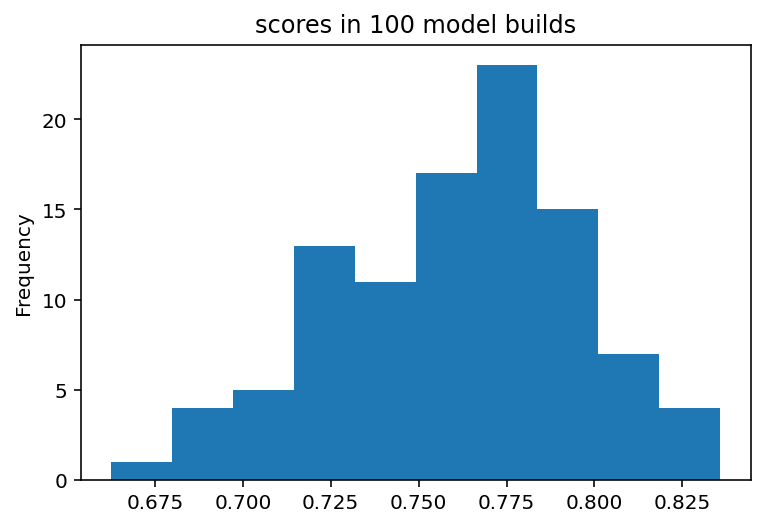

In [13]:
pd.Series(out).plot(kind='hist', title='scores in 100 model builds')

In [14]:
np.mean(out)

0.7606865447586624

### Fairness Evaluation

An interesting subset of our data is the upperbound (90% quantile of the data) and the lowerbound (10% quantile of the data) of Spend. We performed a permutation test to see if our final model fairly predicts the data when the we use data with Spend thatis within the lower bound and data with Spend that is within the upper bound.  

**Null Hypothesis**: Our improved model fairly predicts across lower bound Spend and upper bound Spend  
**Alternative Hypothesis**: Our improved model does not fairly predict across lower bound Spend and upper bound Spend

In [15]:
n_repetitions = 1000
perm_test = df2.copy()
lower_bound = perm_test.Spend.quantile(0.10)
upper_bound = perm_test.Spend.quantile(0.90)

top_10 = perm_test.loc[perm_test.Spend >= upper_bound]
bottom_10 = perm_test.loc[perm_test.Spend <= lower_bound]
    
upper_preds = pl.predict(top_10.drop(['Impressions'], axis=1))
lower_preds = pl.predict(bottom_10.drop(['Impressions'], axis=1))
    
upper_rmse = np.sqrt(np.mean((upper_preds - top_10.Impressions)**2))
lower_rmse = np.sqrt(np.mean((lower_preds - bottom_10.Impressions)**2))
    
obs_stat = abs(upper_rmse - lower_rmse)

diffs = []
for _ in range(n_repetitions):
    
    shuffled_col = (
        perm_test['Spend']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )
    
    shuffled = (
        perm_test
        .assign(**{
            'Spend': shuffled_col,
        })
    )
    
    top_10 = shuffled.loc[shuffled.Spend >= upper_bound]
    bottom_10 = shuffled.loc[shuffled.Spend <= lower_bound]
    
    upper_preds = pl.predict(top_10.drop(['Impressions'], axis=1))
    lower_preds = pl.predict(bottom_10.drop(['Impressions'], axis=1))
    
    upper_rmse = np.sqrt(np.mean((upper_preds - top_10.Impressions)**2))
    lower_rmse = np.sqrt(np.mean((lower_preds - bottom_10.Impressions)**2))
    
    test_stat = abs(upper_rmse - lower_rmse)
    diffs.append(test_stat)

np.mean(np.array(diffs) < obs_stat)

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\bl4ck\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or coun

0.0

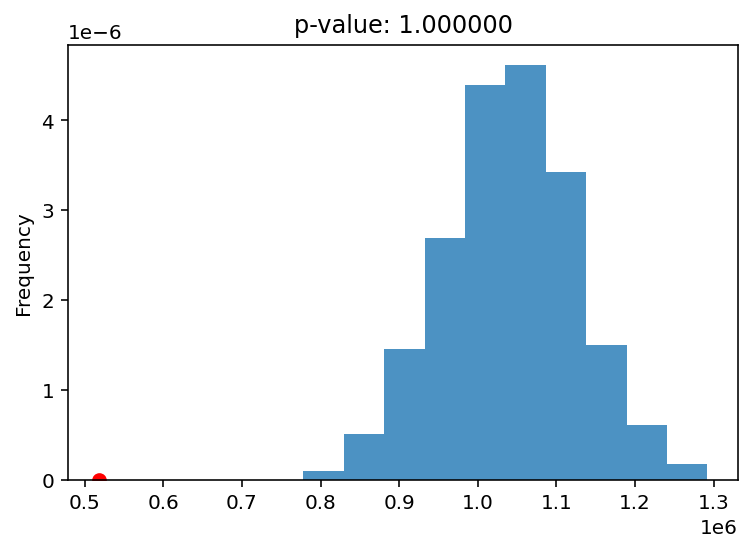

In [16]:
pval = np.mean(np.array(diffs) > obs_stat)
pd.Series(np.array(diffs)).plot(kind='hist',density=True,alpha=0.8,title='p-value: %f'%pval)
plt.scatter(obs_stat,0,color='red',s=40);

Since the observed value does not even lie within the histogram, we reject the null hypothesis. This suggests our improved model does not predict accurately across the lower and upper bounds of Spend.

In [17]:
obs_stat

517705.05176153313